# Example 4-2: Finite element modeling of 2D frames


We will consider a simply supported glulam beam in this example. The beam is 4 meters long, 0.05 meters wide and 0.2 meters high. The mass of the member and non-structural mass is 50 kg/m. Use two beam elements to model the beam, as shown in the figure below

<img src=".\figures\Fig_4_3.svg">

## Define the finite element model
We start by defining the nodes and the elements of the finite element model by defining an array of nodes where the first column contains the node numbers, the second the $x$ coordinates, and the last column contains the $z$ coordinates. We also define elements by an array where the first column contains the element numbers. The second includes the first node, and the third the second node, while the last column can be used to define the element type is the model consists of elements with different properties.

<Figure size 432x288 with 0 Axes>

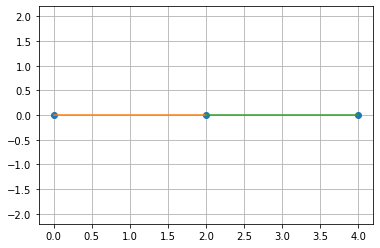

In [20]:
import numpy as np
from scipy import linalg as spla
from matplotlib import pyplot as plt

nodes = np.array([[1, 0,0],
[2, 2, 0],
[3, 4, 0]],dtype=float)

elements = np.array([[1, 1, 2, 1],
[2, 2, 3, 1]])

def plot_fe_model(nodes,elements):
    
    hor_size = np.max(nodes[:,1]) - np.min(nodes[:,1])
    hor_mid = 1/2*(np.max(nodes[:,1]) + np.min(nodes[:,1]))
    
    vert_size = np.max(nodes[:,2]) - np.min(nodes[:,2])
    vert_mid = 1/2*(np.max(nodes[:,2]) + np.min(nodes[:,2]))
    
    max_dim = np.max([hor_size,vert_size])*1.1
    
    plt.figure()
    plt.show()
    plt.plot(nodes[:,1],nodes[:,2],"o")
    
    for k in range(elements.shape[0]):
        x1 = [nodes[nodes[:,0]==elements[k,1],1],nodes[nodes[:,0]==elements[k,2],1] ]
        x2 = [nodes[nodes[:,0]==elements[k,1],2],nodes[nodes[:,0]==elements[k,2],2] ]
        
        plt.plot(x1,x2)
        
    plt.xlim([hor_mid-max_dim/2, hor_mid+max_dim/2])
    plt.ylim([vert_mid-max_dim/2, vert_mid+max_dim/2])
    plt.grid()
    
    #for k in range(nodes.shape[0]):
        #plt.text(nodes[k,1],nodes[k,2], str(nodes[k,0]))

plot_fe_model(nodes,elements)


## Mass and stiffness matrices of a beam element in local and global coordinates

The beam element has six degrees of freedom, and the stiffness and mass matrices in the local coordinate system are defined by

<img src=".\figures\Fig_4_2_1.svg">
                        
$$ \mathbf{k} = \left[ \begin{array}{cccccc} 
\frac{EA}{L} & 0 & 0 & -\frac{EA}{L} & 0 & 0 \\
0 & \frac{12EI}{L^3} & -\frac{6EI}{L^2} & 0 & -\frac{12EI}{L^3} & -\frac{6EI}{L^2} \\
0 & -\frac{6EI}{L^2} & \frac{4EI}{L} & 0 & \frac{6EI}{L^2} & \frac{2EI}{L} \\
-\frac{EA}{L} & 0 & 0 & \frac{EA}{L} & 0 & 0 \\
0 & -\frac{12EI}{L^3} & \frac{6EI}{L^2} & 0 & \frac{12EI}{L^3} & \frac{6EI}{L^2}  \\
0 & -\frac{6EI}{L^2}  & \frac{2EI}{L}  & 0 & \frac{6EI}{L^2}  & \frac{4EI}{L}  \\
\end{array}   \right]  $$


$$ \mathbf{m} = \frac{mL}{420} \left[ \begin{array}{cccccc} 
140 & 0 & 0 & 70 & 0 & 0 \\
0 & 156 & -22L & 0 & 54 & 13L \\
0 & -22L & 4L^2 & 0 & -13L & -3L^2 \\
70 & 0 & 0 & 140 & 0 & 0 \\
0 & 54 & -13L & 0 & 156 & 22L  \\
0 & 13L  & -3L^2  & 0 & 22L  & 4L^2 \\
\end{array}   \right]  $$

It is also necessary to obtain the stiffness and mass matrix for a beam element with an arbitrary orientation. This can be achieved by defining a transformation matrix between the local (beam element)
and the global coordinate system.

The transform can be defined considering the unit vectors defining the direction of the beam element.

<img src=".\figures\Fig_4_2.svg">

$$ \bar{\mathbf{T}}_{G2L} = \left[ \begin{array}{ccc} cos(\theta) & sin(\theta) & 0 \\
                                                -sin(\theta) & cos(\theta) & 0 \\
                                                0 & 0 & 1\end{array}\right]  $$
                                                
The transformation matrix considering all degrees of freedom of the element, becomes

$$ \mathbf{T}_{G2L} = \left[ \begin{array}{ccc} \mathbf{T}_{G2L} & \mathbf{0} \\
                                                \mathbf{0}& \mathbf{T}_{G2L}\end{array}\right]  $$
                                                
The stiffness and mass matrix for a beam element in global coordinates can be obtained by

$$ \mathbf{k} = \mathbf{T}^T_{G2L} \mathbf{k} \mathbf{T}_{G2L} $$

$$ \mathbf{m} = \mathbf{T}^T_{G2L} \mathbf{m} \mathbf{T}_{G2L} $$




In [2]:
def beam_element(E,A,I,rho,x1,x2):
    """
    Parameters
    ----------
    E : float
        Modulus of elasticity
    A : flat
        section area
    I : float
        second moment of area
    rho : float
        material density
    x1 : float
        x,y coordinates of node 1
    x2 : float
        a,y coordinates of node 2

    Returns
    -------
    k_global : float
        element stiffness matrix is global coordinates
    m_global : float
        DESCRIPTION.
        element mass matrix in global coordinates

    """
    L = ((x2-x1) @ (x2-x1))**0.5
    
    EA = E*A
    EI = E*I
    
    k_local = np.array([[EA/L, 0, 0, -EA/L, 0, 0],
                        [0, 12*EI/L**3, -6*EI/L**2, 0, -12*EI/L**3, -6*EI/L**2 ],
                        [0, -6*EI/L**2, 4*EI/L, 0, 6*EI/L**2, 2*EI/L],
                        [-EA/L, 0, 0, EA/L, 0, 0],
                        [0, -12*EI/L**3, 6*EI/L**2, 0, 12*EI/L**3, 6*EI/L**2],
                        [0, -6*EI/L**2, 2*EI/L, 0, 6*EI/L**2, 4*EI/L]])
    
    m_local = rho*A*L/420*np.array([[140, 0, 0, 70, 0, 0],
                        [0, 156, -22*L, 0, 54, 13*L],
                        [0, -22*L, 4*L**2, 0, -13*L, -3*L**2],
                        [70, 0, 0, 140, 0, 0],
                        [0, 54, -13*L, 0, 156, 22*L],
                        [0, 13*L, -3*L**2, 0, 22*L, 4*L**2]])
    
    e1 = (x2-x1)/L    
    e2 = np.cross(np.array([0, 0, 1]),np.append(e1,0))
    e2 = e2[0:-1]
    

    T_glob2loc = np.vstack((e1,e2))
    T_glob2loc = spla.block_diag(T_glob2loc,1.0)
    T_glob2loc_element = spla.block_diag(T_glob2loc,T_glob2loc)
    
     
    k_global = T_glob2loc_element.T @ k_local @ T_glob2loc_element
    m_global = T_glob2loc_element.T @ m_local @ T_glob2loc_element
    
    return k_global, m_global

## Mass and stiffness matrix of a system of beam elements

The assembly of the finite element model can be done straightforwardly by adding the contributions from each element to the system matrices. It is convenient to split the element matrices into four submatrices as follows.

$$ \mathbf{k} = \left[ \begin{array}{cc} \mathbf{k}_{11} & \mathbf{k}_{12} \\ \mathbf{k}_{21} & \mathbf{k}_{22}  \end{array}\right] $$

The figure below shows the system mass or stiffness matrix for an element model with ten nodes. As seen in the figure, ten nodes imply that there are ten sub-matrices. Each submatrix is 3x3 for the element that we are considering. Consider an element connected to nodes 3 and 7. The four submatrices are added to the system mass or stiffness matrix, as shown in the figure. All elements are added to the system mass and stiffness one by one, following the nodal connectivity. 
                     
<img src=".\figures\Fig_4_2_2.svg">

In [25]:
E = 1.0e10
A = 0.05*0.2
I = 1/12*0.05*0.2**3
rho = 50/A

dofs_in_nodes = 3

def assembly(nodes,elements,dofs_in_nodes,E,A,I,rho):
    mass_matrix = np.zeros((nodes.shape[0]*dofs_in_nodes,nodes.shape[0]*dofs_in_nodes))
    stiffness_matrix = np.zeros((nodes.shape[0]*dofs_in_nodes,nodes.shape[0]*dofs_in_nodes)) 
    
    for k in range(elements.shape[0]):
        node_index1 = np.where(nodes[:,0]==elements[k,1])[0][0]
        node_index2 = np.where(nodes[:,0]==elements[k,2])[0][0]   
        
        x1 = nodes[node_index1,1:]
        x2 = nodes[node_index2,1:]    
        
        k_global, m_global = beam_element(E,A,I,rho,x1,x2)
        
        stiffness_matrix[dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1),dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1)] = stiffness_matrix[dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1),dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1)] + k_global[0:dofs_in_nodes,0:dofs_in_nodes]
        stiffness_matrix[dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1),dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1)] = stiffness_matrix[dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1),dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1)] + k_global[0:dofs_in_nodes,dofs_in_nodes:] 
        stiffness_matrix[dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1),dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1)] = stiffness_matrix[dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1),dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1)] + k_global[dofs_in_nodes:,0:dofs_in_nodes] 
        stiffness_matrix[dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1),dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1)] = stiffness_matrix[dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1),dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1)] + k_global[dofs_in_nodes:,dofs_in_nodes:] 
        
        mass_matrix[dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1),dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1)] = mass_matrix[dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1),dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1)] + m_global[0:dofs_in_nodes,0:dofs_in_nodes]
        mass_matrix[dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1),dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1)] = mass_matrix[dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1),dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1)] + m_global[0:dofs_in_nodes,dofs_in_nodes:] 
        mass_matrix[dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1),dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1)] = mass_matrix[dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1),dofs_in_nodes*node_index1:dofs_in_nodes*(node_index1+1)] + m_global[dofs_in_nodes:,0:dofs_in_nodes] 
        mass_matrix[dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1),dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1)] = mass_matrix[dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1),dofs_in_nodes*node_index2:dofs_in_nodes*(node_index2+1)] + m_global[dofs_in_nodes:,dofs_in_nodes:] 
        
    return stiffness_matrix, mass_matrix

stiffness_matrix, mass_matrix = assembly(nodes,elements,dofs_in_nodes,E,A,I,rho)
        

## Boundary conditions

There are several ways to introduce boundary conditions to the finite element model. A straightforward alternative is to introduce the degrees of freedom by kinematic condensation.

$$ \mathbf{v} = \mathbf{T}_{BC} \mathbf{v}_{BC}  $$

We can start by defining the transformation matrix as the identity matrix and then delete all columns corresponding to constrained degrees of freedom. If kinematic constraints are formed by relations between the degrees of freedom, which might be the case if boundary conditions that do not follow the global coordinate system are introduced. The system matrices for the constrained finite element model can be obtained by

$$ \mathbf{K}_{BC} = \mathbf{T}^T_{BC} \mathbf{K} \mathbf{T}_{BC} $$


The beam we consider is simply supported in the left end, which implies that $v_1=v_2=0$. There is a roller bearing on the other end, but it is not aligned with the global coordinate system. The roller bearing introduces a relation between the degrees of freedom $\frac{v_8}{v_7} = \tan{\theta}$

<img src=".\figures\Fig_4_3.svg">

The equations describing the kinematic constraints are thus defined by

$$ \left[ \begin{array}{c} v_1  \\ v_2  \\ v_3  \\ v_4  \\ v_5  \\ v_6  \\ v_7 \\ v_8  \\ v_9 \end{array} \right] =
\left[ \begin{array}{ccccccc} 0 & 0 & 0 & 0 & 0 & 0  \\
                                                 0 & 0 & 0 & 0 & 0 & 0  \\
                                                 1 & 0 & 0 & 0 & 0 & 0  \\
                                                 0 & 1 & 0 & 0 & 0 & 0 \\
                                                 0 & 0 & 1 & 0 & 0 & 0\\
                                                 0 & 0 & 0 & 1 & 0 & 0 \\
                                                 0 & 0 & 0 & 0 & \frac{1}{\tan{\theta}} & 0 \\
                                                 0 & 0 & 0 & 0 & 1 & 0 \\
                                                 0 & 0 & 0 & 0 & 0 & 1
                                                 \end{array}\right] 
                                                 \left[ \begin{array}{c} v_3  \\ v_4  \\ v_5  \\ v_6 \\ v_8 \\ v_9 \end{array} \right] $$
                                                 

In [4]:
T_BC = np.eye(nodes.shape[0]*dofs_in_nodes)
T_BC[6,7] = 1.0/(np.tan(np.pi/4))  # remember that the first index is 0!
T_BC = np.delete(T_BC,[0, 1 , dofs_in_nodes*2],axis=1)

stiffness_matrix_bc = T_BC.T @ stiffness_matrix @ T_BC
mass_matrix_bc = T_BC.T @ mass_matrix @ T_BC

## Modes and frequencies
The natural frequencies and the modes of the constrained model can be obtained by solving the eigenvalue problem

In [5]:
lam,vec = spla.eig(stiffness_matrix_bc,mass_matrix_bc)
indx = np.argsort(lam)
lam = lam[indx]

vec = vec[:,indx]

f = np.real(lam**0.5)/2/np.pi

We can then plot the vibration modes.

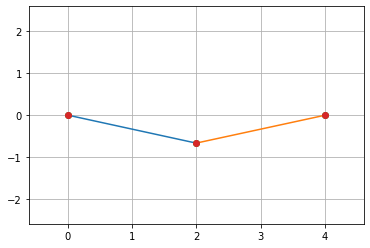

In [6]:
u = T_BC @ vec[:,0]

skd = 1

def plot_deformed_model(nodes,elements,u,skd):
    
    hor_size = np.max(nodes[:,1]) - np.min(nodes[:,1])
    hor_mid = 1/2*(np.max(nodes[:,1]) + np.min(nodes[:,1]))
    
    vert_size = np.max(nodes[:,2]) - np.min(nodes[:,2])
    vert_mid = 1/2*(np.max(nodes[:,2]) + np.min(nodes[:,2]))
    
    max_dim = np.max([hor_size,vert_size])*1.3

    nodes_deformed = np.copy(nodes)
    nodes_deformed[:,1] = nodes_deformed[:,1]+skd*u[0::3]
    nodes_deformed[:,2] = nodes_deformed[:,2]+skd*u[1::3]
    plt.figure()
    for k in range(elements.shape[0]):
        x1 = [nodes_deformed[nodes_deformed[:,0]==elements[k,1],1],nodes_deformed[nodes_deformed[:,0]==elements[k,2],1] ]
        x2 = [nodes_deformed[nodes_deformed[:,0]==elements[k,1],2],nodes_deformed[nodes_deformed[:,0]==elements[k,2],2] ]
        
        plt.plot(x1,x2)
    plt.plot(nodes[:,1]+skd*u[0::3],nodes[:,2]+skd*u[1::3],"o")
    plt.plot(nodes_deformed[:,1],nodes_deformed[:,2],"o")
    
    plt.xlim([hor_mid-max_dim/2, hor_mid+max_dim/2])
    plt.ylim([vert_mid-max_dim/2, vert_mid+max_dim/2])
    plt.grid()

plot_deformed_model(nodes,elements,u,skd)

## Refine element model
There are far too few elements in the finite element model to obtain accurate results. The element model is refined by splitting the elements by changing the nodes and element arrays. New nodes can be appended to the existing ones while we redefine all elements since the connectivity change.

In [23]:
element_refine_factor = 10

def refine_mesh(nodes,elements,T_BC,element_refine_factor,dofs_in_nodes):

    nodes_add = np.zeros(((element_refine_factor-1)*elements.shape[0],3))    
    nodes_add[:,0] = np.arange(0,nodes_add.shape[0])+ 10000
    new_nodes_element = element_refine_factor-1
    
    refined_T_BC = spla.block_diag(T_BC,np.eye(nodes_add.shape[0]*dofs_in_nodes))
        
    refined_elements = np.zeros((element_refine_factor * elements.shape[0],3))    
    refined_elements[:,0] = np.arange(1,elements.shape[0]*element_refine_factor+1)    
    
    for k in range(elements.shape[0]):
        
        refined_elements[k*element_refine_factor:(k+1)*element_refine_factor,1] = np.hstack((elements[k,1], np.arange(k*new_nodes_element,(k+1)*new_nodes_element) +10000))
        refined_elements[k*element_refine_factor:(k+1)*element_refine_factor,2] = np.hstack(( np.arange(k*new_nodes_element,(k+1)*new_nodes_element) +10000, elements[k,2]))
        
        
        node_index1 = np.where(nodes[:,0]==elements[k,1])[0][0]
        node_index2 = np.where(nodes[:,0]==elements[k,2])[0][0] 
        
        x1 = nodes[node_index1,1:]
        x2 = nodes[node_index2,1:] 
        
        nodes_add[k*new_nodes_element:(k+1)*new_nodes_element,1] = np.linspace(x1[0],x2[0],element_refine_factor+1)[1:-1]
        nodes_add[k*new_nodes_element:(k+1)*new_nodes_element,2] = np.linspace(x1[1],x2[1],element_refine_factor+1)[1:-1]
    
    refined_nodes = np.vstack((nodes,nodes_add))
    
    return refined_nodes, refined_elements, refined_T_BC

refined_nodes, refined_elements, refined_T_BC = refine_mesh(nodes,elements,T_BC,element_refine_factor,dofs_in_nodes)
    

<Figure size 432x288 with 0 Axes>

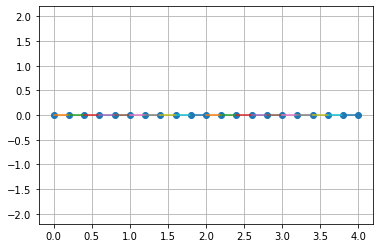

In [24]:
plot_fe_model(refined_nodes,refined_elements)

In [9]:
stiffness_matrix, mass_matrix = assembly(refined_nodes,refined_elements,dofs_in_nodes,E,A,I,rho)

stiffness_matrix_bc = refined_T_BC.T @ stiffness_matrix @ refined_T_BC
mass_matrix_bc = refined_T_BC.T @ mass_matrix @ refined_T_BC

In [10]:
lam,vec = spla.eig(stiffness_matrix_bc,mass_matrix_bc)
indx = np.argsort(lam)
lam = lam[indx]

vec = vec[:,indx]

f = np.real(lam**0.5)/2/np.pi

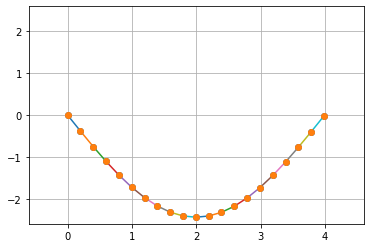

In [16]:
u = refined_T_BC @ vec[:,0]

skd = 10

plot_deformed_model(refined_nodes,refined_elements,u,skd)